In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from scipy import stats

import re
from pprint import pprint

# scraping modules
from requests import get
from bs4 import BeautifulSoup

import unicodedata
import re
import json

from wordcloud import WordCloud

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import acquire as ac
import prepare as pr
import preprocessing as pp
import evaluate as ev
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rc('figure', figsize=(16,8))
plt.rc('font', size=14)
sns.set_palette('pastel')

In [3]:
df = pr.wrangle_readme_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 0 to 225
Data columns (total 5 columns):
repo                            226 non-null object
language                        226 non-null object
readme_contents                 226 non-null object
clean_readme_contents           226 non-null object
len_of_clean_readme_contents    226 non-null int64
dtypes: int64(1), object(4)
memory usage: 10.6+ KB


In [5]:
df.head()

,repo,language,readme_contents,clean_readme_contents,len_of_clean_readme_contents
0,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...,316
1,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...,well hello repository meant provide example fo...,66
2,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www....",div align center tensorflow image tf logo soci...,1138
3,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public repo official list smartapp...,44
4,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap getbootstrap as...,1048


### Hypothesis Testing
- t-test:
    - $H_0$: The average amount of words used in a repo written in go is no different than the population average of words written in a readme.
    - $H_a$: The average amount of words used in a repo written in go is different than the population average of words written in a readme.

In [6]:
df.groupby('language')['len_of_clean_readme_contents'].mean()

language
C                    521.100000
C#                   280.500000
C++                  719.937500
CSS                  542.800000
Go                  2912.400000
Groovy                44.000000
HTML                 428.285714
Java                 597.416667
JavaScript          1422.294118
Jupyter Notebook     644.083333
Kotlin               446.000000
PHP                  564.555556
PowerShell           171.000000
Python              2246.814815
R                    350.666667
Ruby                 361.714286
Rust                 757.500000
Shell                490.250000
TypeScript           658.444444
Vue                 1176.333333
Name: len_of_clean_readme_contents, dtype: float64

In [7]:
go = df[df.language == 'Go']

In [8]:
go.head()

,repo,language,readme_contents,clean_readme_contents,len_of_clean_readme_contents
31,kubernetes/kubernetes,Go,# Kubernetes\n\n[![GoDoc Widget]][GoDoc] [![CI...,kubernetes godoc widget godoc cii best practic...,301
62,moby/moby,Go,The Moby Project\n================\n\n![Moby P...,moby project moby project logo static file mob...,306
95,getlantern/lantern,Go,## 蓝灯(Lantern)最新版本下载 版本![](https://bitbucket.o...,lantern bitbucket getlantern lantern binary ra...,271
99,golang/go,Go,# The Go Programming Language\n\nGo is an open...,go programming language go open source program...,145
119,astaxie/build-web-application-with-golang,Go,# Multiple Language Versions\r\n\r\n* [(HTML -...,multiple language version html pdf gitbook leg...,130


In [9]:
t, p = stats.ttest_1samp(go.len_of_clean_readme_contents, df.len_of_clean_readme_contents.mean())

print(f't = {t:.2f}')
print(f'p = {p:.2f}')
print("Conclusion:")
a = 1 - .99
if p < a:
    print('We reject the null hypothesis')
else:
    print('We Fail to reject the null hypothesis')


t = 0.84
p = 0.42
Conclusion:
We Fail to reject the null hypothesis


## Distribution of languages used

In [10]:
df_lang_count = pd.DataFrame(df.language.value_counts())

Total Observations

In [11]:
# 231 total observation
df_lang_count.sum()

language    226
dtype: int64

#### Seems a bit sparse on some of the languages with less than 5 projects done in that language, deciding to lop all of the languages less than 5 into a bin labeled 'other' 

In [12]:
df_lang_count

,language
JavaScript,51
Java,36
Python,27
C++,16
HTML,14
Jupyter Notebook,12
C,10
Go,10
TypeScript,9
PHP,9


We're creating this function that will remove all languages with less than 5 readme's and convert those into a observation titled 'others'.

> **the languages included in 'others':
Shell, R, Vue, Groovy, Kotlin, Powershell, Rust, & C#**

In [13]:
def get_others(df):
    '''
    input pandas series with value counts, convert it into a dataframe 
    to get new dataframe with dataframe with others category which is the 
    sum of the data past the first 13 rows
    '''
    df.reset_index()
    df2 = df[12:].sum()
    df2 = pd.DataFrame(df2).reset_index()
    df2 = df2.rename(columns={0:'language'})
    df = df.append(df2)
    df = df.drop(columns=(['index']))
    df = df.rename(index={0:'other'})
    df = df.sort_values(by='language', ascending=False)
    data = df.iloc[:13]
    return data

In [14]:
df_lang_count = get_others(df_lang_count)

In [15]:
df_lang_count.sum()

language    226
dtype: int64

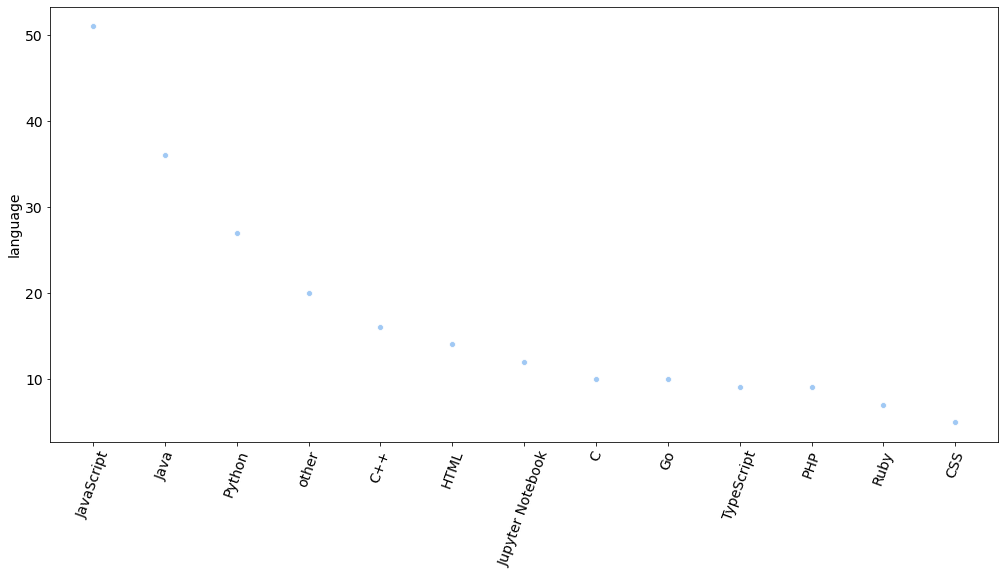

In [16]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.scatterplot(data=df_lang_count, x=x, y=y)
plt.xticks(rotation=70)

plt.show()

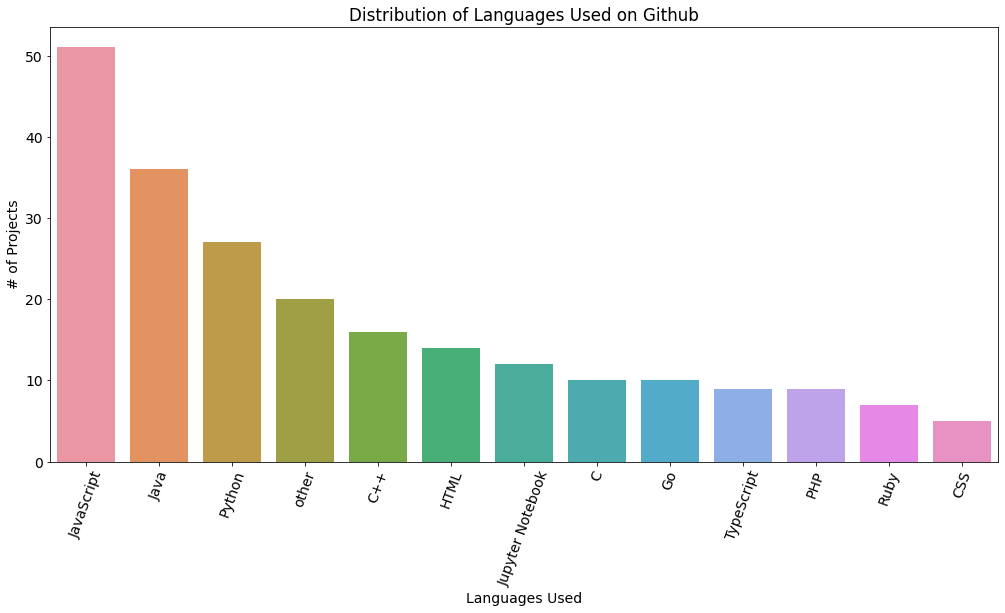

In [17]:
plt.figure(figsize=(17,8))
x = df_lang_count.index
y = df_lang_count.language
sns.barplot(data=df_lang_count, x=x, y=y)

plt.title("Distribution of Languages Used on Github")
plt.ylabel('# of Projects')
plt.xlabel('Languages Used')

plt.xticks(rotation=70)
plt.show()

the languages included in 'others':
Shell, R, Vue, Groovy, Kotlin, Powershell, Rust, C#, ApacheConf, Objective-C, Scala, TeX, Dart, & Rascal

## exploring words used

Simple function to clean, remove spaces, and add them to a list for further exploration

In [18]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

implementing the clean function

In [19]:
df_clean = clean(' '.join(df.readme_contents))

In [20]:
df_clean

['introduction',
 'second',
 'programming',
 'assignment',
 'require',
 'write',
 'r',
 'function',
 'able',
 'cache',
 'potentially',
 'timeconsuming',
 'computation',
 'example',
 'taking',
 'mean',
 'numeric',
 'vector',
 'typically',
 'fast',
 'operation',
 'however',
 'long',
 'vector',
 'may',
 'take',
 'long',
 'compute',
 'mean',
 'especially',
 'computed',
 'repeatedly',
 'eg',
 'loop',
 'content',
 'vector',
 'changing',
 'may',
 'make',
 'sense',
 'cache',
 'value',
 'mean',
 'need',
 'looked',
 'cache',
 'rather',
 'recomputed',
 'programming',
 'assignment',
 'take',
 'advantage',
 'scoping',
 'rule',
 'r',
 'language',
 'manipulated',
 'preserve',
 'state',
 'inside',
 'r',
 'object',
 'example',
 'caching',
 'mean',
 'vector',
 'example',
 'introduce',
 'operator',
 'used',
 'assign',
 'value',
 'object',
 'environment',
 'different',
 'current',
 'environment',
 'two',
 'function',
 'used',
 'create',
 'special',
 'object',
 'store',
 'numeric',
 'vector',
 'cache',
 'm

A wordcloud  depicting the most commonly used words among all Github projects observed

(-0.5, 1199.5, 899.5, -0.5)

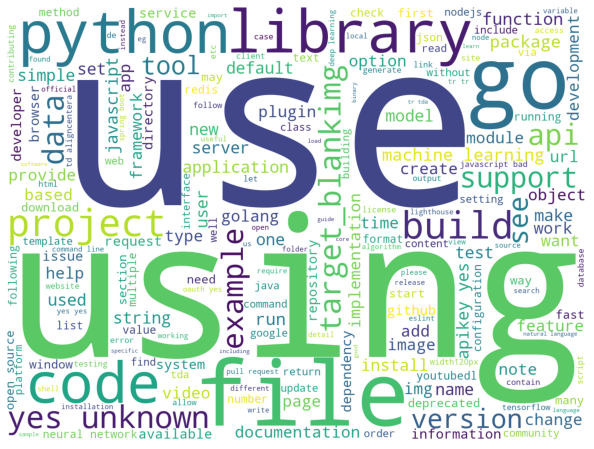

In [21]:
text = ' '.join(df_clean)
wc = WordCloud(background_color='white', width=1200, height=900)
img = wc.generate(text)

plt.imshow(img)
plt.axis('off')

## 25 most common words in readme


In [22]:
common_words = pd.Series(df_clean).value_counts()
common_words.sort_values().tail(25)

target_blankimg     412
javascript          412
example             425
machine             430
version             438
api                 445
run                 448
support             449
see                 457
function            465
install             478
learning            508
1                   509
unknown             533
project             539
build               562
yes                 664
code                746
using               758
data                767
python              802
file                825
use                 880
library            1014
go                 1070
dtype: int64

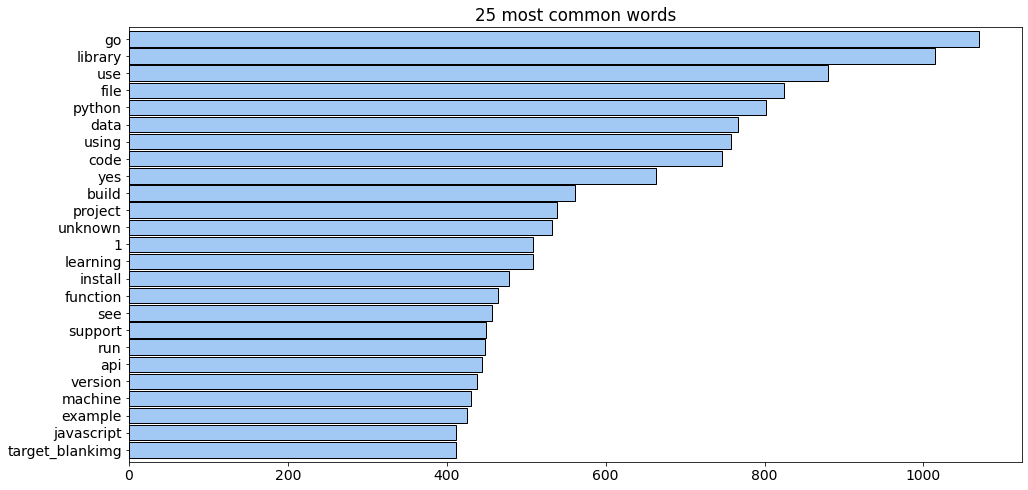

In [23]:
most_common_words = common_words.sort_values().tail(25)
most_common_words.drop(columns='all').plot.barh(width=.9, ec='black', title='25 most common words')

## Does the length of the README vary by programming language?

In [24]:
df.head(1)

,repo,language,readme_contents,clean_readme_contents,len_of_clean_readme_contents
0,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...,introduction second programming assignment req...,316


In [25]:
df2 = df[['language', 'clean_readme_contents']]

In [26]:
df2

,language,clean_readme_contents
0,R,introduction second programming assignment req...
1,HTML,well hello repository meant provide example fo...
2,C++,div align center tensorflow image tf logo soci...
3,Groovy,smartthings public repo official list smartapp...
4,JavaScript,align center href getbootstrap getbootstrap as...
...,...,...
221,TypeScript,ngx admin imgur omcxwz png alt eva design syst...
222,R,swirl course collection interactive course use...
223,C++,jennic platform added note detail project plea...
224,Go,etcd go report card goreportcard badge etcd io...


In [27]:
#languages = ['Shell', 'R', 'Vue', 'Groovy', 'Kotlin', 'Powershell', 'Rust', 'C#', 'ApacheConf', 'Objective-C', 'Scala', 'TeX', 'Dart', 'Rascal']

#df2.language = df.columns.str.replace(languages, 'other')

In [28]:
#df2['cleaned'] = ' '.join(df.clean_readme_contents)
df2['cleaned_readme'] = df2.clean_readme_contents.apply(clean)

In [29]:
df2['length_of_readme'] = df2.cleaned_readme.apply(len)
df2.head()

,language,clean_readme_contents,cleaned_readme,length_of_readme
0,R,introduction second programming assignment req...,"[introduction, second, programming, assignment...",316
1,HTML,well hello repository meant provide example fo...,"[well, hello, repository, meant, provide, exam...",66
2,C++,div align center tensorflow image tf logo soci...,"[div, align, center, tensorflow, image, tf, lo...",1138
3,Groovy,smartthings public repo official list smartapp...,"[smartthings, public, repo, official, list, sm...",44
4,JavaScript,align center href getbootstrap getbootstrap as...,"[align, center, href, getbootstrap, getbootstr...",1048


> Scatter plot where length of readme is y-axis, x-axis is how many programming languages and hue is label of programming language

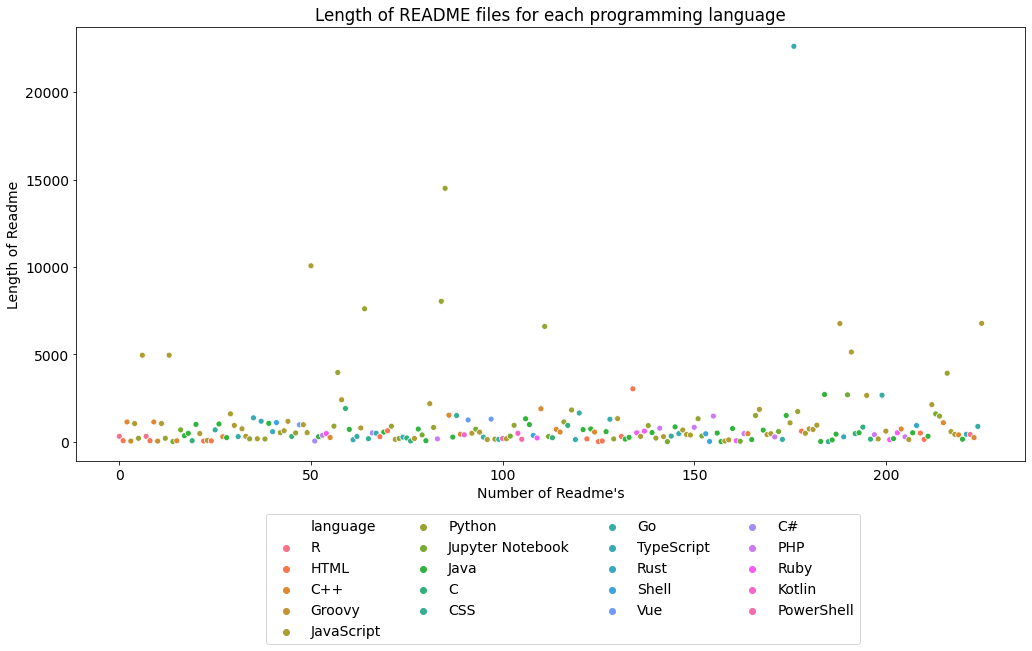

In [30]:
plt.figure(figsize=(17,8))
plt.title('Length of README files for each programming language')
x
x = df2.index
y = df2.length_of_readme
hue = df2.language
sns.scatterplot(data=df_lang_count, x=x, y=y, hue=hue)
plt.ylabel('Length of Readme')
plt.xlabel('Number of Readme\'s')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(0.2, -0.12), loc=2, borderaxespad=0., ncol=4)

plt.show()

In [31]:
df2 = df2.sort_values(by='length_of_readme', ascending=False)

Which Languages have the longest readme's?

In [32]:
df_len = df2.groupby('language').mean()

In [33]:
df_len.length_of_readme

language
C                    521.100000
C#                   280.500000
C++                  719.937500
CSS                  542.800000
Go                  2912.400000
Groovy                44.000000
HTML                 428.285714
Java                 597.416667
JavaScript          1422.294118
Jupyter Notebook     644.083333
Kotlin               446.000000
PHP                  564.555556
PowerShell           171.000000
Python              2246.814815
R                    350.666667
Ruby                 361.714286
Rust                 757.500000
Shell                490.250000
TypeScript           658.444444
Vue                 1176.333333
Name: length_of_readme, dtype: float64

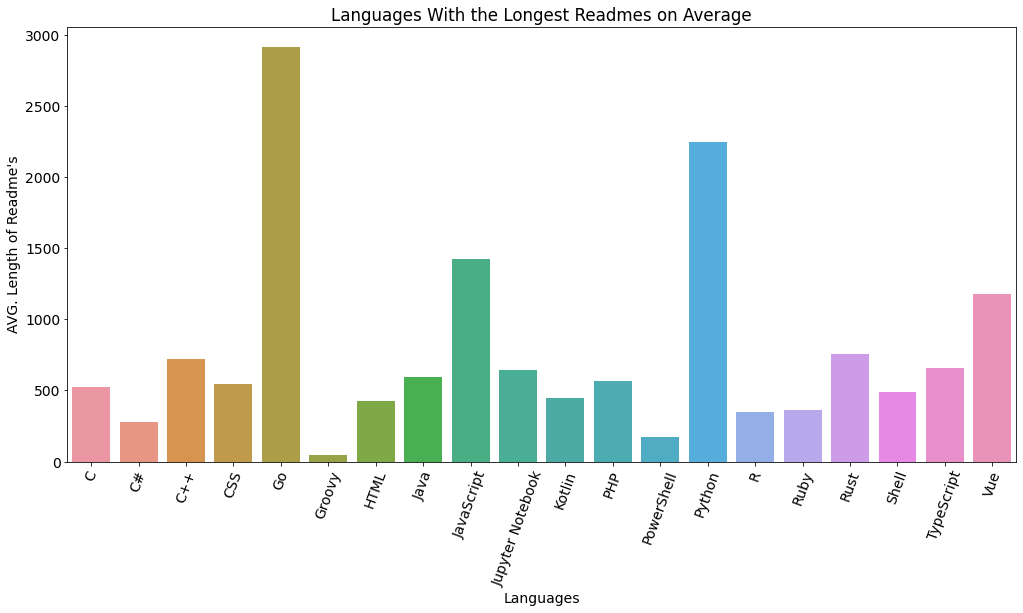

In [34]:
plt.figure(figsize=(17,8))
x = df_len.index
y = df_len.length_of_readme
sns.barplot(data=df_len, x=x, y=y)

plt.title("Languages With the Longest Readmes on Average")
plt.ylabel('AVG. Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

Median longest readme's

In [35]:
df_len_med = df2.groupby('language').median()

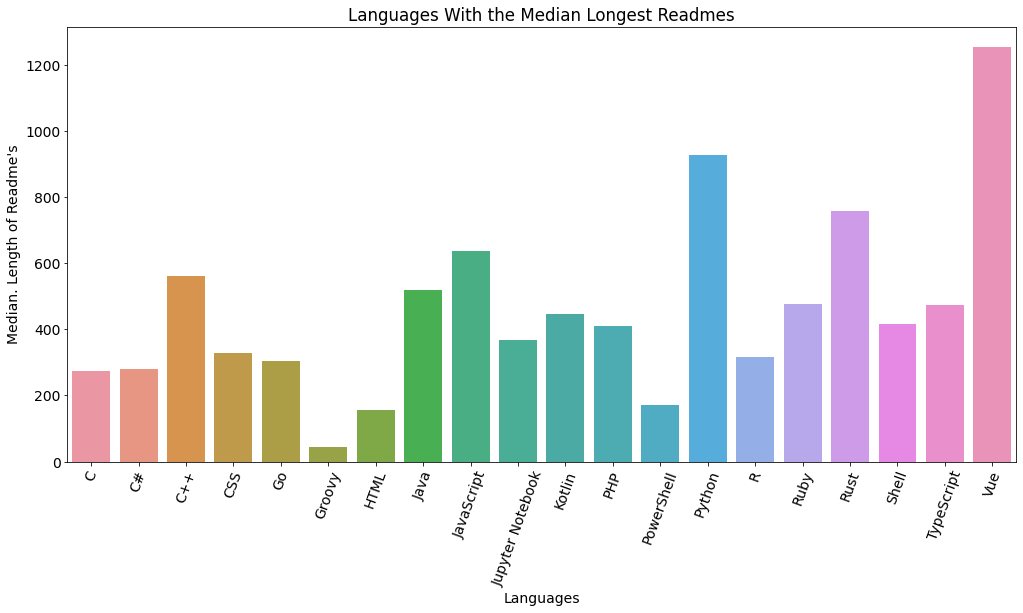

In [36]:
plt.figure(figsize=(17,8))
x = df_len_med.index
y = df_len_med.length_of_readme
sns.barplot(data=df_len_med, x=x, y=y)

plt.title("Languages With the Median Longest Readmes")
plt.ylabel('Median. Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

### Word Frequency by language

In [37]:
df2.head()

,language,clean_readme_contents,cleaned_readme,length_of_readme
176,Go,awesome go build status travis ci avelino awes...,"[awesome, go, build, status, travis, ci, aveli...",22628
85,Python,awesome machine learning awesome cdn rawgit si...,"[awesome, machine, learning, awesome, cdn, raw...",14505
50,JavaScript,airbnb javascript style guide mostly reasonabl...,"[airbnb, javascript, style, guide, mostly, rea...",10071
84,Python,build status travis ci ytdl youtube dl branch ...,"[build, status, travis, ci, ytdl, youtube, dl,...",8042
64,Python,awesome python awesome cdn rawgit sindresorhus...,"[awesome, python, awesome, cdn, rawgit, sindre...",7612


### biggest readme's by language

In [38]:
words_by_lang = df2.groupby('language').max()
words_by_lang = words_by_lang.sort_values(by='length_of_readme', ascending=False)
words_by_lang.length_of_readme

language
Go                  22628
Python              14505
JavaScript          10071
HTML                 3033
Java                 2710
Jupyter Notebook     2690
C                    1909
C++                  1894
CSS                  1507
PHP                  1475
TypeScript           1374
Vue                  1302
Shell                1102
Rust                  934
Ruby                  613
C#                    512
Kotlin                488
R                     420
PowerShell            193
Groovy                 44
Name: length_of_readme, dtype: int64

In [39]:
words_by_lang

,clean_readme_contents,cleaned_readme,length_of_readme
language,,,
Go,project build status codecov io godoc codebeat...,"[project, build, status, codecov, io, godoc, c...",22628
Python,scrapy image shield io pypi scrapy target pypi...,"[scrapy, image, shield, io, pypi, scrapy, targ...",14505
JavaScript,welcome bracket build status travis ci adobe b...,"[welcome, bracket, build, status, travis, ci, ...",10071
HTML,well hello repository meant provide example fo...,"[well, hello, repository, meant, provide, exam...",3033
Java,zheng build status travis ci shuzheng zheng br...,"[zheng, build, status, travis, ci, shuzheng, z...",2710
Jupyter Notebook,thinkstats text supporting code think stats nd...,"[thinkstats, text, supporting, code, think, st...",2690
C,welcome lean git source openwrt package openwr...,"[welcome, lean, git, source, openwrt, package,...",1909
C++,raw githubusercontent dmlc dmlc io master logo...,"[raw, githubusercontent, dmlc, dmlc, io, maste...",1894
CSS,website static html website using semantic tag...,"[website, static, html, website, using, semant...",1507


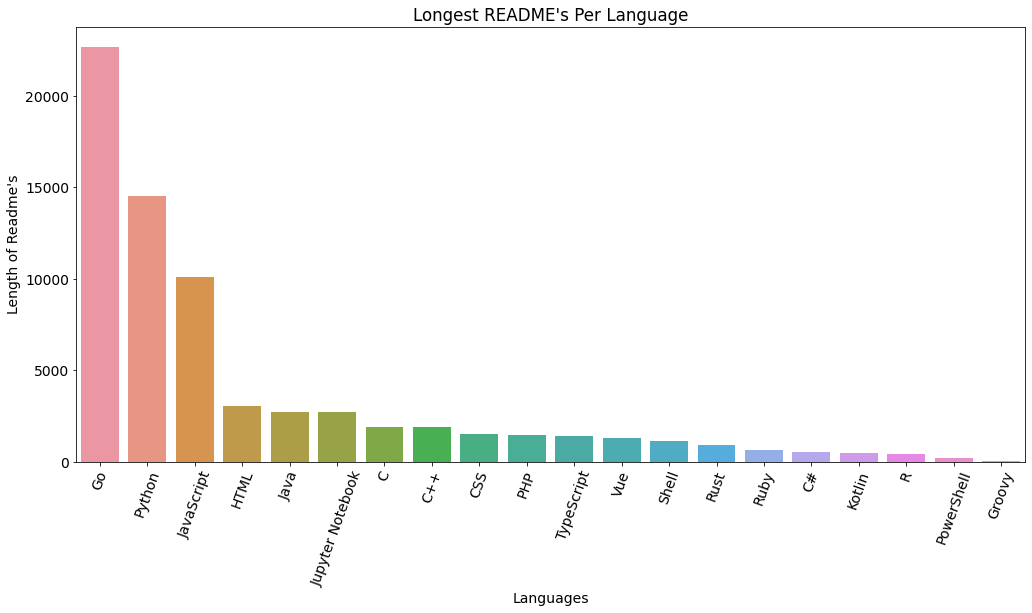

In [40]:
plt.figure(figsize=(17,8))
x = words_by_lang.index
y = words_by_lang.length_of_readme
sns.barplot(data=words_by_lang, x=x, y=y)

plt.title("Longest README\'s Per Language")
plt.ylabel('Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

### Total words used per language

In [41]:
total_words_per_lang = df2.groupby('language').sum()
total_words_per_lang = words_by_lang.sort_values(by='length_of_readme', ascending=False)
total_words_per_lang.length_of_readme

language
Go                  22628
Python              14505
JavaScript          10071
HTML                 3033
Java                 2710
Jupyter Notebook     2690
C                    1909
C++                  1894
CSS                  1507
PHP                  1475
TypeScript           1374
Vue                  1302
Shell                1102
Rust                  934
Ruby                  613
C#                    512
Kotlin                488
R                     420
PowerShell            193
Groovy                 44
Name: length_of_readme, dtype: int64

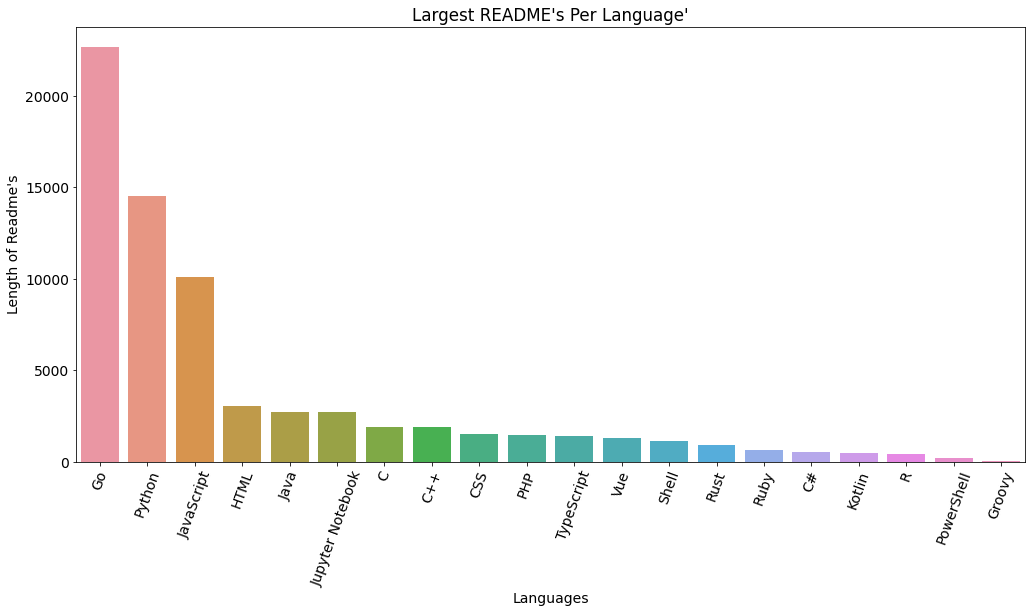

In [42]:
plt.figure(figsize=(17,8))
x = total_words_per_lang.index
y = total_words_per_lang.length_of_readme
sns.barplot(data=total_words_per_lang, x=x, y=y)

plt.title("Largest README\'s Per Language'")
plt.ylabel('Length of Readme\'s')
plt.xlabel('Languages')

plt.xticks(rotation=70)
plt.show()

### What are the most common words per language?

In [43]:
df2.head(1)

,language,clean_readme_contents,cleaned_readme,length_of_readme
176,Go,awesome go build status travis ci avelino awes...,"[awesome, go, build, status, travis, ci, aveli...",22628


In [44]:
df2.head(1)

,language,clean_readme_contents,cleaned_readme,length_of_readme
176,Go,awesome go build status travis ci avelino awes...,"[awesome, go, build, status, travis, ci, aveli...",22628


In [45]:
go_words = clean(' '.join(df2[df2.language == 'Go'].clean_readme_contents))
python_words = clean(' '.join(df2[df2.language == 'Python'].clean_readme_contents))
javascript_words = clean(' '.join(df2[df2.language == 'JavaScript'].clean_readme_contents))
all_words = clean(' '.join(df2.clean_readme_contents))

In [46]:
go_freq = pd.Series(go_words).value_counts()
python_freq = pd.Series(python_words).value_counts()
javascript_freq = pd.Series(javascript_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [47]:
word_counts = (pd.concat([all_freq, go_freq, python_freq, javascript_freq], axis=1, sort=True)
              .set_axis(['all', 'go', 'python', 'javascript'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [48]:
word_counts.head()

,all,go,python,javascript
9,424,2,3,269
aa,56,0,48,3
aaaa,1,0,1,0
aaaaaaaaaac,1,0,0,1
aaaaaaaaaai,1,0,0,1


### What are the most frequently occuring words?

In [49]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,go,python,javascript
go,1890,1701,90,47
io,1588,145,304,440
href,1377,0,108,780
python,1299,16,917,2
data,1109,95,594,239
library,1103,390,485,103
master,1070,60,168,203
code,1055,92,280,238
api,1035,155,443,255
html,1029,51,343,315


In [50]:
def word_freq(df):
    '''
    creates a list of words by language
    drops them into a series & turns them into a dataframe showing
    the most frequent words per language
    '''
    # lang_words
    go_words = ' '.join(df2[df2.language == 'Go'].clean_readme_contents).split()
    python_words = ' '.join(df2[df2.language == 'Python'].clean_readme_contents).split()
    javascript_words = ' '.join(df2[df2.language == 'JavaScript'].clean_readme_contents).split()
    java_words = ' '.join(df2[df2.language == 'Java'].clean_readme_contents).split()
    c_words = ' '.join(df2[df2.language == 'C'].clean_readme_contents).split()
    cplus_words = ' '.join(df2[df2.language == 'C++'].clean_readme_contents).split()
    HTML_words = ' '.join(df2[df2.language == 'HTML'].clean_readme_contents).split()
    Jupyter_words = ' '.join(df2[df2.language == 'Jupyter Notebook'].clean_readme_contents).split()
    Vue_words = ' '.join(df2[df2.language == 'Vue'].clean_readme_contents).split()
    CSS_words = ' '.join(df2[df2.language == 'CSS'].clean_readme_contents).split()
    shell_words = ' '.join(df2[df2.language == 'Shell'].clean_readme_contents).split()
    obj_words = ' '.join(df2[df2.language == 'Objective C'].clean_readme_contents).split()
    rust_words = ' '.join(df2[df2.language == 'Rust'].clean_readme_contents).split()
    Csharp_words = ' '.join(df2[df2.language == 'C#'].clean_readme_contents).split()
    kotlin_words = ' '.join(df2[df2.language == 'Kotlin'].clean_readme_contents).split()
    r_words = ' '.join(df2[df2.language == 'R'].clean_readme_contents).split()
    dart_words = ' '.join(df2[df2.language == 'Dart'].clean_readme_contents).split()
    scala_words = ' '.join(df2[df2.language == 'Scala'].clean_readme_contents).split()
    powershell_words = ' '.join(df2[df2.language == 'Powershell'].clean_readme_contents).split()
    Rascal_words = ' '.join(df2[df2.language == 'Rascal'].clean_readme_contents).split()
    tex_words = ' '.join(df2[df2.language == 'TeX'].clean_readme_contents).split()
    groovy_words = ' '.join(df2[df2.language == 'Groovy'].clean_readme_contents).split()
    apache_words = ' '.join(df2[df2.language == 'ApacheConf'].clean_readme_contents).split()
    PHP_words = ' '.join(df2[df2.language == 'PHP'].clean_readme_contents).split()
    type_words = ' '.join(df2[df2.language == 'TypeScript'].clean_readme_contents).split()
    all_words = ' '.join(df2.clean_readme_contents).split
    
    # Series
    go_freq = pd.Series(go_words).value_counts()
    python_freq = pd.Series(python_words).value_counts()
    javascript_freq = pd.Series(javascript_words).value_counts()
    java_freq = pd.Series(java_words).value_counts()
    c_freq = pd.Series(c_words).value_counts()
    cplus_freq = pd.Series(cplus_words).value_counts()
    html_freq = pd.Series(HTML_words).value_counts()
    jup_freq = pd.Series(Jupyter_words).value_counts()
    vue_freq = pd.Series(Vue_words).value_counts()
    css_freq = pd.Series(CSS_words).value_counts()
    shell_freq = pd.Series(shell_words).value_counts()
    obj_freq = pd.Series(obj_words).value_counts()
    rust_freq = pd.Series(rust_words).value_counts()
    csharp_freq = pd.Series(Csharp_words).value_counts()
    kotlin_freq = pd.Series(kotlin_words).value_counts()
    r_freq = pd.Series(r_words).value_counts()
    dart_freq = pd.Series(dart_words).value_counts()
    scala_freq = pd.Series(scala_words).value_counts()
    powershell_freq = pd.Series(powershell_words).value_counts()
    rascal_freq = pd.Series(Rascal_words).value_counts()
    tex_freq = pd.Series(tex_words).value_counts()
    groovy_freq = pd.Series(groovy_words).value_counts()
    apache_freq = pd.Series(apache_words).value_counts()
    php_freq = pd.Series(PHP_words).value_counts()
    type_freq = pd.Series(type_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()
    
    # Concatting into df
    word_counts = (pd.concat([all_freq, go_freq, python_freq, javascript_freq, java_freq,
                              c_freq, cplus_freq, html_freq, jup_freq, vue_freq, css_freq,
                              shell_freq, obj_freq, rust_freq, csharp_freq, kotlin_freq,
                              r_freq, dart_freq, scala_freq, powershell_freq, rascal_freq,
                              tex_freq, groovy_freq, apache_freq, php_freq, type_freq 
                             ], axis=1, sort=True)
              .set_axis(['all', 'go', 'python', 'javascript', 'java', 'c', 'c++', 'html', 'jupyter notebook',
                        'vue', 'css', 'shell', 'objective c', 'rust', 'c#', 'kotlin', 'r', 'dart', 'scala', 'powershell',
                        'rascal', 'tex', 'groovy', 'apacheconf', 'php', 'typescript'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))
    
    return word_counts
    

In [51]:
word = word_freq(df2)

In [52]:
word

,all,go,python,javascript,java,c,c++,html,jupyter notebook,vue,...,r,dart,scala,powershell,rascal,tex,groovy,apacheconf,php,typescript
<built-in method split of str object at 0x139ef0000>,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
&#9;,0,2,3,269,63,0,0,31,2,0,...,0,0,0,0,0,0,0,0,54,0
aa,0,0,48,3,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaa,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaaaaaaaaac,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zynga,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zypper,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zyszys,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zz,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Are there any words that uniquely identify what language a readme is in?

In [53]:
pd.concat([word_counts[word_counts.go == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.go == 0].sort_values(by='python').tail(6),
          word_counts[word_counts.javascript == 0].sort_values(by='go').tail(6),
          word_counts[word_counts.javascript == 0].sort_values(by='python').tail(6),
          word_counts[word_counts.python == 0].sort_values(by='javascript').tail(6),
           word_counts[word_counts.python == 0].sort_values(by='go').tail(6)
          ])

,all,go,python,javascript
npm,471,0,0,365
sponsor,546,0,0,400
requireactive,524,0,0,524
webpack,735,0,0,720
opencollective,946,0,1,740
href,1377,0,108,780
title,287,0,112,21
py,206,0,138,0
transformer,140,0,140,0
ml,211,0,147,0


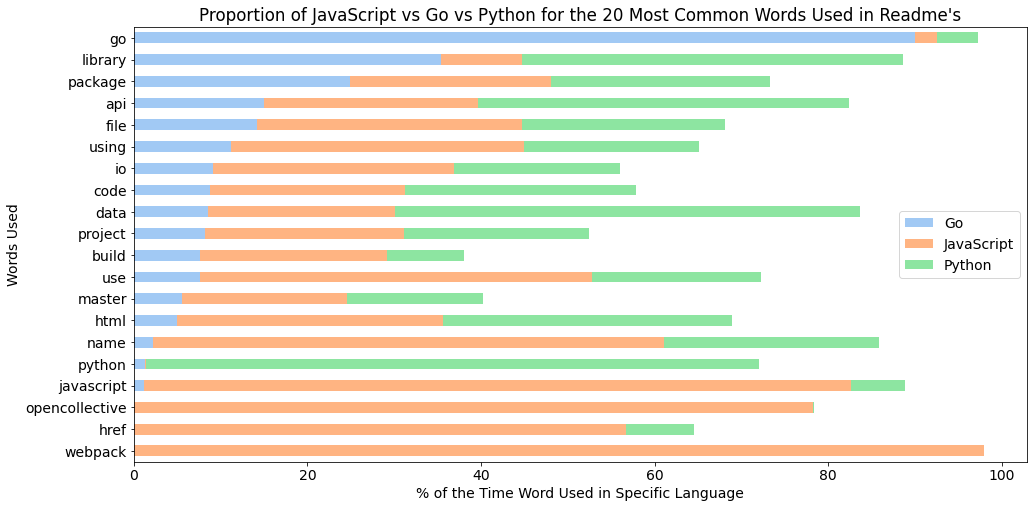

In [54]:
(word_counts
 .assign(Go=word_counts.go / word_counts['all'] * 100,
         JavaScript=word_counts.javascript / word_counts['all'] * 100,
        Python=word_counts.python / word_counts['all'] * 100)
 .sort_values(by='all')
 [['Go', 'JavaScript', 'Python']]
 .tail(20)
 .sort_values('Go')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs Go vs Python for the 20 Most Common Words Used in Readme\'s')
plt.ylabel('Words Used')
plt.xlabel('% of the Time Word Used in Specific Language')
plt.show()

### Most used words visualized

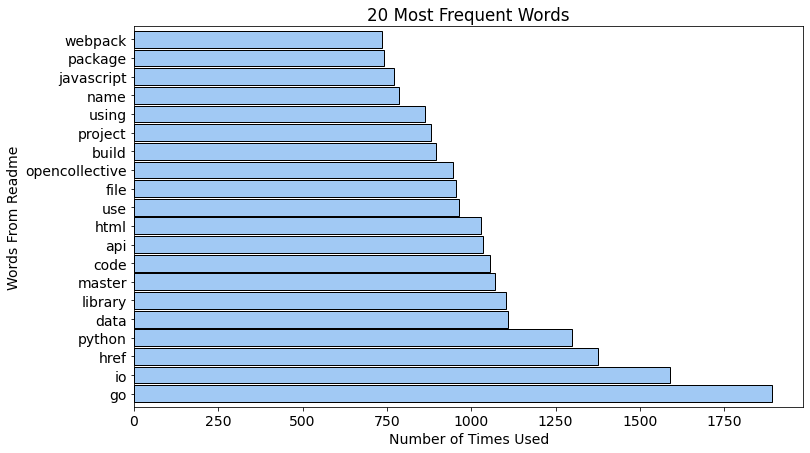

In [55]:
plt.figure(figsize=(12,7))
word_counts["all"].sort_values(ascending=False).head(20).plot.barh(width=.9, ec='black',
                                                                  title='20 Most Frequent Words')

plt.ylabel('Words From Readme')
plt.xlabel('Number of Times Used')
plt.show()


## What does the distribution of IDFs look like for the most common words?


In [56]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df_clean)

In [57]:
tfidf = TfidfVectorizer()
bag_of_words = tfidf.fit_transform(df_clean)

In [58]:
s_1 = pd.Series(dict(zip(tfidf.get_feature_names(), tfidf.idf_))).sort_values()

In [59]:
df3 = pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names()).T

In [60]:
s_1.sort_values()

go                             6.050502
library                        6.104206
use                            6.245793
file                           6.310256
python                         6.338496
                                ...    
viewslayoutpug                12.333703
viewspartialsflashpug         12.333703
viewspartialsfooterpug        12.333703
171controlstatements          12.333703
zyszyshttpsgithubcomzyszys    12.333703
Length: 36886, dtype: float64

---
# Model

In [61]:
# create evaluation DataFrame
evaluation = pd.DataFrame(columns=["model_type", "train_accuracy", "test_accuracy"])

---
## Model #1: TF-IDF Bigrams Decision Tree

In [62]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(max_depth=5, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Gini, 5", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.5


This more than likely luck that the model performed better on test than train. We can find a better model.

In [63]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(max_depth=6, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Gini, 6", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261


In [64]:
# create tfidf_bigrams vectorizer object
tfidf_bigrams = TfidfVectorizer(ngram_range=(2, 2))

# use tfidf_bigrams object to create model features
X = tfidf_bigrams.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
tree = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=56)

# fit model object
tree.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Bigrams Entropy, 6", model_object=tree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783


---
## Model #2: TF-IDF Logistic Regression

In [65]:
# create tfidf vectorizer object
tfidf = TfidfVectorizer()

# use tfidf object to create model features
X = tfidf.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
logit = LogisticRegression(random_state=56)

# fit model object
logit.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Logistic Regression", model_object=logit, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783


---
## Model #3: TF-IDF Naïve Bayes

In [66]:
# create tfidf vectorizer object
tfidf = TfidfVectorizer()

# use tfidf object to create model features
X = tfidf.fit_transform(df.clean_readme_contents)

# establish model target
y = df.language

# split data
X_train, X_test, y_train, y_test = pp.split_repo_data(X, y)

# create model object
nb = MultinomialNB()

# fit model object
nb.fit(X_train, y_train)

# append evaluation
evaluation = ev.append_evaluation(evaluation, model_type="TF-IDF Naïve Bayes", model_object=nb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
evaluation.sort_values(by="test_accuracy", ascending=False)

,model_type,train_accuracy,test_accuracy
0,"TF-IDF Bigrams Gini, 5",0.405556,0.500000
1,"TF-IDF Bigrams Gini, 6",0.450000,0.478261
3,TF-IDF Logistic Regression,0.605556,0.456522
2,"TF-IDF Bigrams Entropy, 6",0.550000,0.434783
4,TF-IDF Naïve Bayes,0.450000,0.413043
